In [1]:
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
rasters = rio.open("dane/rasters.vrt") 
vector = gpd.read_file("dane/proby.gpkg")
colnames = [os.path.splitext(os.path.basename(file))[0] for file in rasters.files[1:]]
coords = zip(vector.geometry.x,vector.geometry.y)
samples = [x for x in rasters.sample(coords)]
samples = gpd.GeoDataFrame(samples,columns=colnames).join(vector)

In [3]:
from sklearn.linear_model import LinearRegression as ls
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


In [4]:
columns = samples.columns.drop(['tempr','landuse','geometry']) # temperatura zostaje
rows = ~samples.isna().any(axis=1) 
X = samples.loc[rows,columns]
y = samples.loc[rows,'tempr']

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA())])
pipe.fit(X)
Xs = pipe.transform(X)

In [7]:
scaler = StandardScaler()
scaler.fit(X)
Xs = scaler.transform(X)
Xs = pd.DataFrame(Xs,columns = X.columns,index=X.index)

<Axes: >

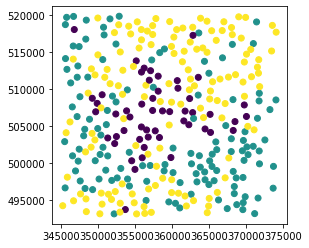

In [19]:
k_means = KMeans(n_clusters=3,n_init='auto').fit(Xs)
clusters = k_means.predict(Xs)+1
samples = samples.loc[rows].assign(clusters=clusters)
samples.plot(column="clusters")

In [23]:

model_1 = ls().fit(Xs.loc[clusters==1],y.loc[clusters==1])
model_2 = ls().fit(Xs.loc[clusters==2],y.loc[clusters==2])
model_3 = ls().fit(Xs.loc[clusters==3],y.loc[clusters==3])


In [46]:
pd.DataFrame(zip(model_1.coef_,model_2.coef_,model_3.coef_),index=columns)

,0,1,2
01_roughness,0.042304,-0.185417,0.192746
02_green,0.352364,-0.148245,-0.801140
03_distwaters,-0.170726,0.083541,0.201182
04_terange,-0.157936,-0.055134,-0.105867
05_imperm,-0.007761,0.561530,0.228602
06_highbuildup,0.284399,2.201811,-0.327899
07_buildup,0.391491,0.604079,0.693316
08_road_dens,0.176809,-0.109792,0.267574


### Predykcja modelu

In [24]:
dane_r = rasters.read()
s = dane_r.shape 
flat_r = dane_r.reshape(s[0],s[1]*s[2]).T
flat_r = pd.DataFrame(flat_r,columns=X.columns)
rows_r = ~flat_r.isna().any(axis=1)
Xtr = flat_r.loc[rows_r]

In [39]:
Xtrs = scaler.transform(Xtr)
Xtrs = pd.DataFrame(Xtrs,columns=columns)
clusters_r = k_means.predict(Xtrs)+1 # to nas interesuje


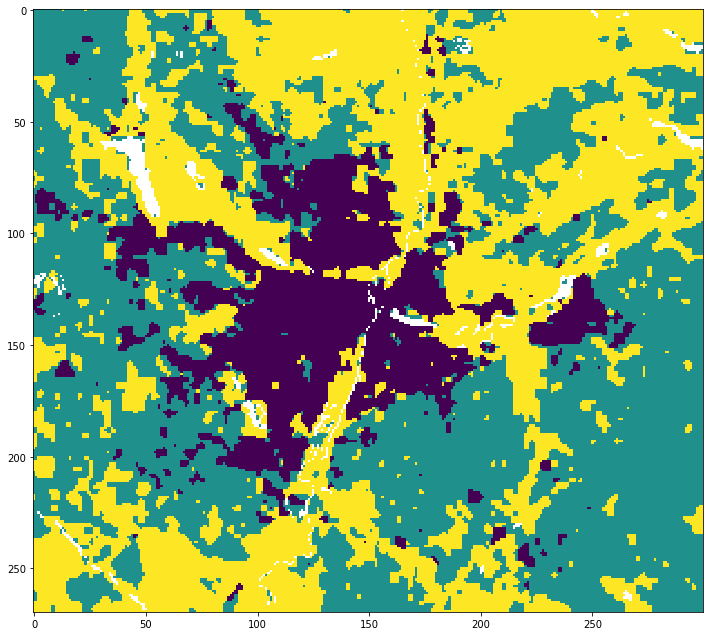

In [40]:
ls_rf = np.full(flat_r.shape[0],np.nan)
ls_rf[rows_r] = clusters_r
ls_matrix = ls_rf.T
ls_matrix = ls_matrix.reshape(s[1],s[2])
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(ls_matrix,interpolation='nearest')

In [50]:
ls_prediction = np.full(Xtrs.shape[0],np.nan)
ls_prediction[clusters_r==1]=model_1.predict(Xtrs.loc[clusters_r==1])
ls_prediction[clusters_r==2]=model_1.predict(Xtrs.loc[clusters_r==2])
ls_prediction[clusters_r==3]=model_1.predict(Xtrs.loc[clusters_r==3])

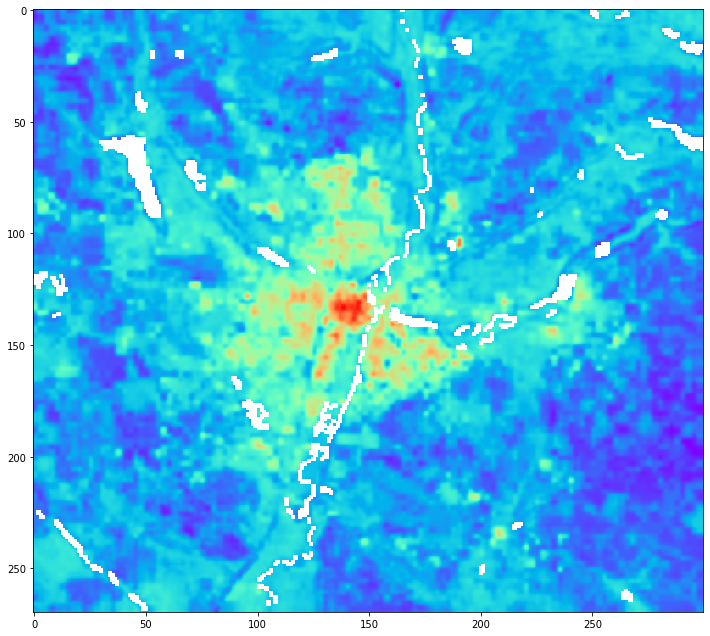

In [61]:
ls_results = np.full(flat_r.shape[0],np.nan)
ls_results[rows_r] = ls_prediction
ls_results = ls_results.T
ls_results = ls_results.reshape(s[1],s[2])
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(ls_results,cmap="rainbow")

In [59]:
s[1]

270